In [1]:
# import required variables
import pandas as pd
import numpy as np
import re
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
# read data
df=pd.read_csv(r'loan\loan.csv',low_memory=False)

In [3]:
# check dataframe shape
df.shape

(39717, 111)

In [4]:
# check null values in each column
pd.options.display.max_rows = 150
df.isnull().sum().loc[df.isnull().sum()>0]

emp_title                          2459
emp_length                         1075
desc                              12940
title                                11
mths_since_last_delinq            25682
mths_since_last_record            36931
revol_util                           50
last_pymnt_d                         71
next_pymnt_d                      38577
last_credit_pull_d                    2
collections_12_mths_ex_med           56
mths_since_last_major_derog       39717
annual_inc_joint                  39717
dti_joint                         39717
verification_status_joint         39717
tot_coll_amt                      39717
tot_cur_bal                       39717
open_acc_6m                       39717
open_il_6m                        39717
open_il_12m                       39717
open_il_24m                       39717
mths_since_rcnt_il                39717
total_bal_il                      39717
il_util                           39717
open_rv_12m                       39717


# Cleaning the Dataset:

In [5]:
# Deleting columns having more than 2500 missing values
df = df.loc[:, (df.isnull().sum(axis=0) <= 2500)]

In [6]:
# Dropping rows with null values
df = df.dropna(subset=['pub_rec_bankruptcies','emp_length','revol_util','last_pymnt_d','last_credit_pull_d'])

### Deleting columns that do not add any value for analysis:
##
###  -> 'id' and 'member_id' is just an identification number which has no value for analysis.
###  -> 'url' is a link that has no value for analysis.
###  -> 'funded_amnt' and 'funded_amnt_inv' has values equivalant to 'loan_amnt'.
### -> 'emp_title' and 'title' are names which is also identifier that has no value for analysing patterns for defaulters
###  -> 'acc_now_delinq' and 'delinq_amnt' has all values as 0, has no variance and cannot get any insights 
###  -> 'application_type' has all value as 'INDIVIDUAL', has no variance and cannot get any insights
###  -> 'policy_code' has all values as 1, has no variance and cannot get any insights
###  -> 'pymnt_plan' has all values as 'n', has no variance and cannot get any insights
###  -> 'zip_code' represents state which we have a separate variable 'addr_state', also zip code has XX in them.
###  -> 'initial_list_status' has all values as 'f', has no variance and cannot get any insights
###  -> 'chargeoff_within_12_mths', 'tax_liens', and 'collections_12_mths_ex_med' has values 0 and nan, has no variance and cannot get any insights

In [7]:
# deleting columns
df = df.drop(['member_id', 'id', 'url', 'funded_amnt', 'funded_amnt_inv', 'emp_title', 'title', 'acc_now_delinq', 'delinq_amnt', 'application_type', 
            'policy_code', 'pymnt_plan', 'zip_code', 'initial_list_status', 'chargeoff_within_12_mths', 'tax_liens', 'collections_12_mths_ex_med'], axis=1)

In [8]:
# checking null values after deleting columns
df.isnull().sum()

loan_amnt                  0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_length                 0
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
purpose                    0
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_d               0
last_pymnt_amnt            0
last_credit_pu

In [9]:
# Change term to integer and remove string 'months'
print('Before: '+str(df.term.unique()))
df['term'] = df['term'].str.replace(r' months', '').astype(np.int64)
print('After: '+str(df.term.unique()))

Before: [' 36 months' ' 60 months']
After: [36 60]


In [10]:
# Change int_rate to float and remove '%' symbol
print('Before: '+str(df.int_rate.unique()[0:5]))
df['int_rate'] = df['int_rate'].str.rstrip('%').astype(np.float64)
print('After: '+str(df.int_rate.unique()[0:5]))

Before: ['10.65%' '15.27%' '15.96%' '13.49%' '12.69%']
After: [10.65 15.27 15.96 13.49 12.69]


In [11]:
# Change revol_util to float and remove '%' symbol
print('Before: '+str(df.revol_util.unique()[0:5]))
df['revol_util'] = df['revol_util'].str.rstrip('%').astype(np.float64)
print('After: '+str(df.revol_util.unique()[0:5]))

Before: ['83.70%' '9.40%' '98.50%' '21%' '53.90%']
After: [83.7  9.4 98.5 21.  53.9]


In [12]:
# Get only the number of years of employment (remove years, +, <)
print('Before: '+str(df.emp_length.unique()))
df['emp_length'][df['emp_length'] == '< 1 year'] = '0'
df['emp_length']=df.emp_length.str.extract('(\d+)').astype(np.int64)
print('After: '+str(df.emp_length.unique()))

Before: ['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years']
After: [10  0  1  3  8  9  4  5  6  2  7]


In [13]:
# separating month and year for date columns
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%y')
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%y')

df['issue_d_month']=df['issue_d'].dt.month
df['issue_d_year']=df['issue_d'].dt.year
df['earliest_cr_line_month']=df['earliest_cr_line'].dt.month
df['earliest_cr_line_year']=df['earliest_cr_line'].dt.year
df['last_pymnt_d_month']=df['last_pymnt_d'].dt.month
df['last_pymnt_d_year']=df['last_pymnt_d'].dt.year
df['earliest_cr_line_month']=df['last_credit_pull_d'].dt.month
df['earliest_cr_line_year']=df['last_credit_pull_d'].dt.year

In [14]:
# dropping date columns
df=df.drop(['issue_d', 'last_credit_pull_d','last_pymnt_d','earliest_cr_line'], axis = 1)

In [15]:
# check unique values
df.nunique().sort_values()

term                           2
loan_status                    3
verification_status            3
pub_rec_bankruptcies           3
home_ownership                 4
pub_rec                        5
issue_d_year                   5
grade                          7
inq_last_6mths                 9
last_pymnt_d_year              9
earliest_cr_line_year         10
delinq_2yrs                   11
emp_length                    11
earliest_cr_line_month        12
last_pymnt_d_month            12
issue_d_month                 12
purpose                       14
sub_grade                     35
open_acc                      38
addr_state                    49
total_acc                     81
int_rate                     337
loan_amnt                    869
revol_util                  1087
out_prncp                   1096
out_prncp_inv               1097
total_rec_late_fee          1274
collection_recovery_fee     2488
dti                         2863
recoveries                  3780
annual_inc

In [16]:
# check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37835 entries, 0 to 39680
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                37835 non-null  int64  
 1   term                     37835 non-null  int64  
 2   int_rate                 37835 non-null  float64
 3   installment              37835 non-null  float64
 4   grade                    37835 non-null  object 
 5   sub_grade                37835 non-null  object 
 6   emp_length               37835 non-null  int64  
 7   home_ownership           37835 non-null  object 
 8   annual_inc               37835 non-null  float64
 9   verification_status      37835 non-null  object 
 10  loan_status              37835 non-null  object 
 11  purpose                  37835 non-null  object 
 12  addr_state               37835 non-null  object 
 13  dti                      37835 non-null  float64
 14  delinq_2yrs           

In [17]:
# Changing datatypes of all categorical columns
columns = ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'addr_state', 
           'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies']
df[columns] = df[columns].astype('category')

In [18]:
# check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37835 entries, 0 to 39680
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   loan_amnt                37835 non-null  int64   
 1   term                     37835 non-null  int64   
 2   int_rate                 37835 non-null  float64 
 3   installment              37835 non-null  float64 
 4   grade                    37835 non-null  category
 5   sub_grade                37835 non-null  category
 6   emp_length               37835 non-null  int64   
 7   home_ownership           37835 non-null  category
 8   annual_inc               37835 non-null  float64 
 9   verification_status      37835 non-null  category
 10  loan_status              37835 non-null  category
 11  purpose                  37835 non-null  category
 12  addr_state               37835 non-null  category
 13  dti                      37835 non-null  float64 
 14  delinq

In [19]:
# check data
pd.set_option('display.max_columns', 50)
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year
0,5000,36,10.65,162.87,B,B2,10,RENT,24000.0,Verified,Fully Paid,credit_card,AZ,27.65,0,1,3,0,13648,83.7,9,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,171.62,0.0,12,2011,5,2016,1,2015
1,2500,60,15.27,59.83,C,C4,0,RENT,30000.0,Source Verified,Charged Off,car,GA,1.00,0,5,3,0,1687,9.4,4,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,12,2011,9,2013,4,2013
2,2400,36,15.96,84.33,C,C5,10,RENT,12252.0,Not Verified,Fully Paid,small_business,IL,8.72,0,2,2,0,2956,98.5,10,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,649.91,0.0,12,2011,5,2016,6,2014
3,10000,36,13.49,339.31,C,C1,10,RENT,49200.0,Source Verified,Fully Paid,other,CA,20.00,0,1,10,0,5598,21.0,37,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,357.48,0.0,12,2011,4,2016,1,2015
4,3000,60,12.69,67.79,B,B5,1,RENT,80000.0,Source Verified,Current,other,OR,17.94,0,0,15,0,27783,53.9,38,524.06,524.06,3513.330000,3513.33,2475.94,1037.39,0.00,0.00,0.00,67.79,0.0,12,2011,5,2016,5,2016


In [20]:
# Saving cleaned dataset 
df.to_csv(r'loan\loan_cleaned.csv',index=False)

# Analysing the Dataset for Defaulters/Charged Off:

Fully Paid     31534
Charged Off     5203
Current         1098
Name: loan_status, dtype: int64


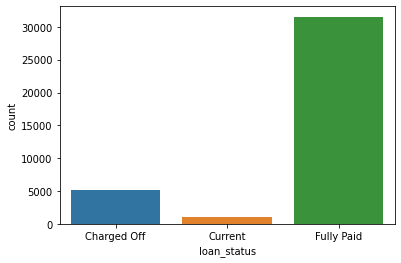

In [21]:
# checking Loan_status count
print(df['loan_status'].value_counts())
ax = sns.countplot(x='loan_status', data=df)

count    37835.000000
mean     11328.321660
std       7477.228389
min        500.000000
25%       5600.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64


<AxesSubplot:xlabel='loan_amnt', ylabel='Density'>

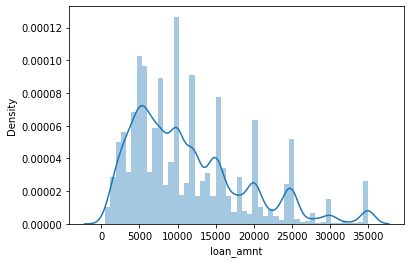

In [22]:
# check loan_amnt distribution
print(df['loan_amnt'].describe())
sns.distplot(df['loan_amnt'])

In [23]:
df.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5203.0,12296.290602,8096.922633,1000.0,6000.0,10000.0,17000.0,35000.0
Current,1098.0,17182.604736,8646.645299,1000.0,12000.0,16000.0,23312.5,35000.0
Fully Paid,31534.0,10964.766601,7223.862728,500.0,5500.0,9600.0,15000.0,35000.0


<AxesSubplot:xlabel='loan_amnt', ylabel='loan_status'>

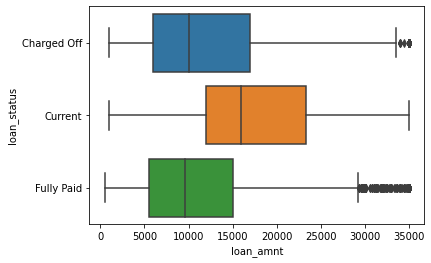

In [24]:
sns.boxplot(y='loan_status',x='loan_amnt',data=df)

<AxesSubplot:xlabel='emp_length', ylabel='count'>

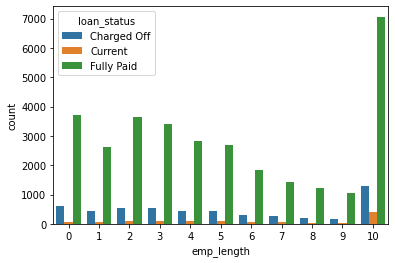

In [25]:
sns.countplot(x='emp_length', hue='loan_status', data=df)

<AxesSubplot:xlabel='loan_status', ylabel='int_rate'>

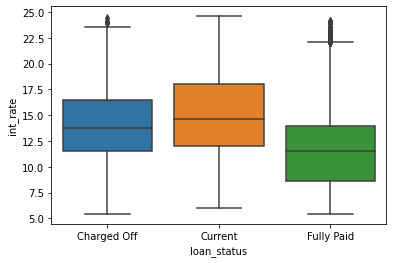

In [26]:
sns.boxplot(y='int_rate', x='loan_status', data=df)

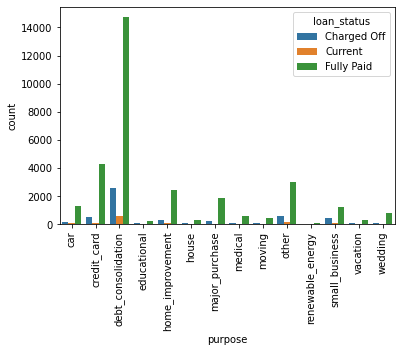

In [27]:
sns.countplot(x='purpose', hue="loan_status", data=df)
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='term', ylabel='count'>

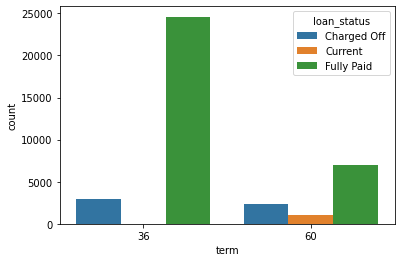

In [28]:
sns.countplot( x="term", hue='loan_status', data=df)

<AxesSubplot:xlabel='home_ownership', ylabel='count'>

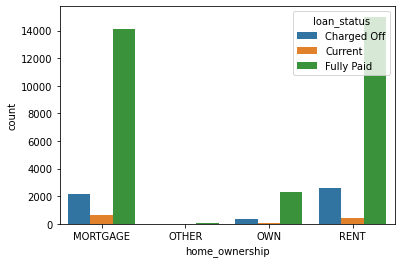

In [29]:
sns.countplot(x='home_ownership',hue='loan_status', data=df)

<AxesSubplot:>

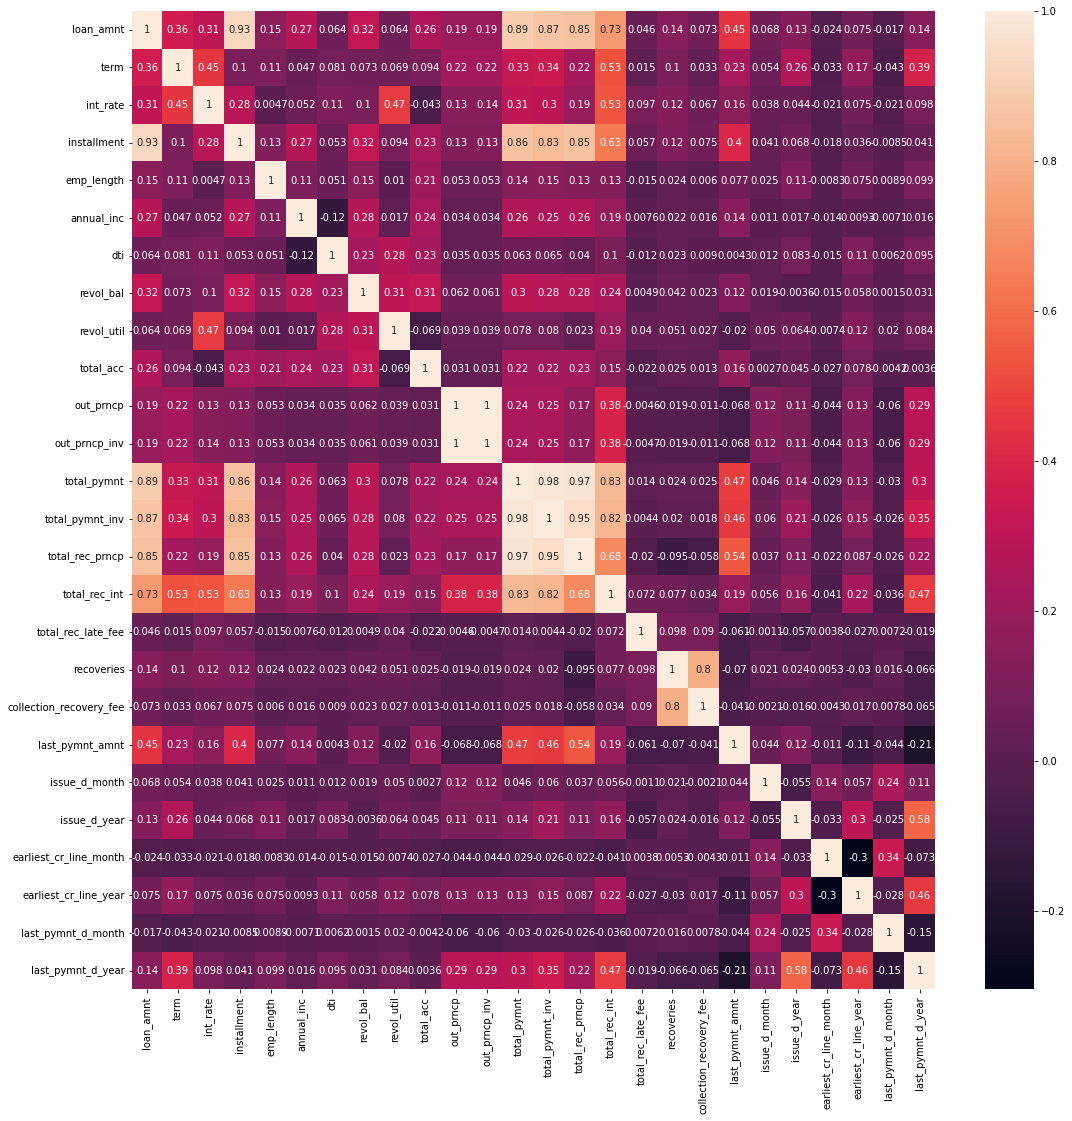

In [30]:
plt.figure(figsize=(18,18))
sns.heatmap(df.corr(),annot=True)

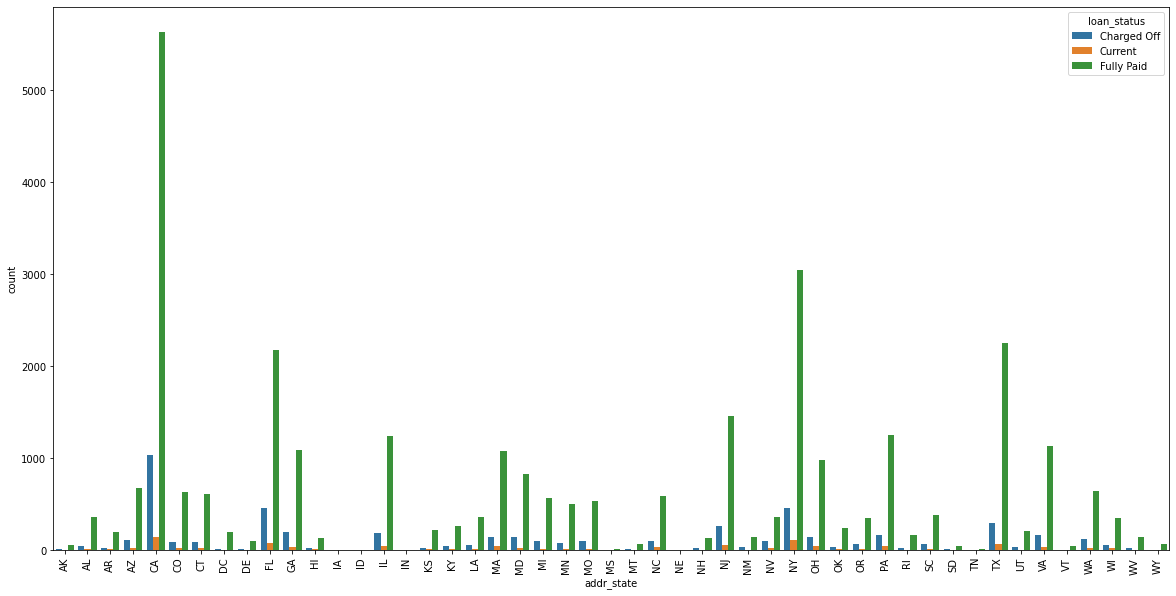

In [31]:
plt.figure(figsize=(20,10))
sns.countplot(hue='loan_status',x='addr_state',data=df)
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='issue_d_year', ylabel='count'>

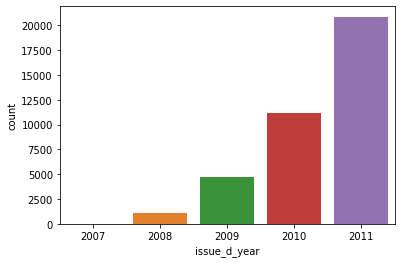

In [32]:
sns.countplot(x='issue_d_year', data=df)

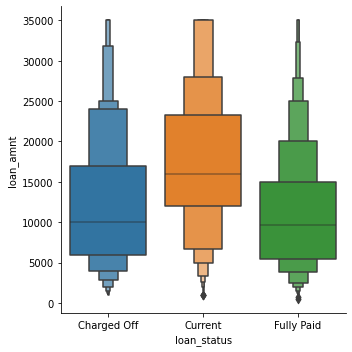

In [33]:
sns.catplot(y='loan_amnt',x='loan_status', kind='boxen', data=df)

<AxesSubplot:xlabel='term', ylabel='count'>

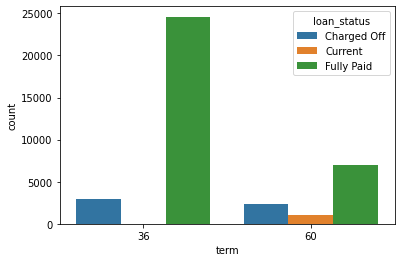

In [34]:
sns.countplot(x='term',data=df,hue='loan_status')

<AxesSubplot:xlabel='grade', ylabel='count'>

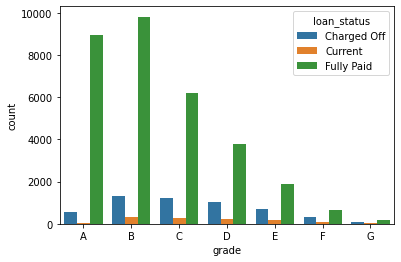

In [35]:
sns.countplot(x='grade',data=df,hue='loan_status')